<a href="https://colab.research.google.com/github/SergeiVKalinin/BO_Research/blob/master/MeasuredNoiseGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Measured and Predictive Noise Gaussian Process

*Prepared by Maxim Ziatdinov (January 2024)*

This notebook illustrates the usage of ```MeasuredNoiseGP``` model that extends the ```ExactGP``` model by allowing the inclusion of measured noise in the GP framework. Unlike standard GP models where noise is typically inferred, this model uses noise values obtained from repeated measurements at the same input points.

Install GPax:

In [1]:
!pip install -q git+https://github.com/ziatdinovmax/gpax

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


Imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import gpax

gpax.utils.enable_x64()

Generate synthetic data:

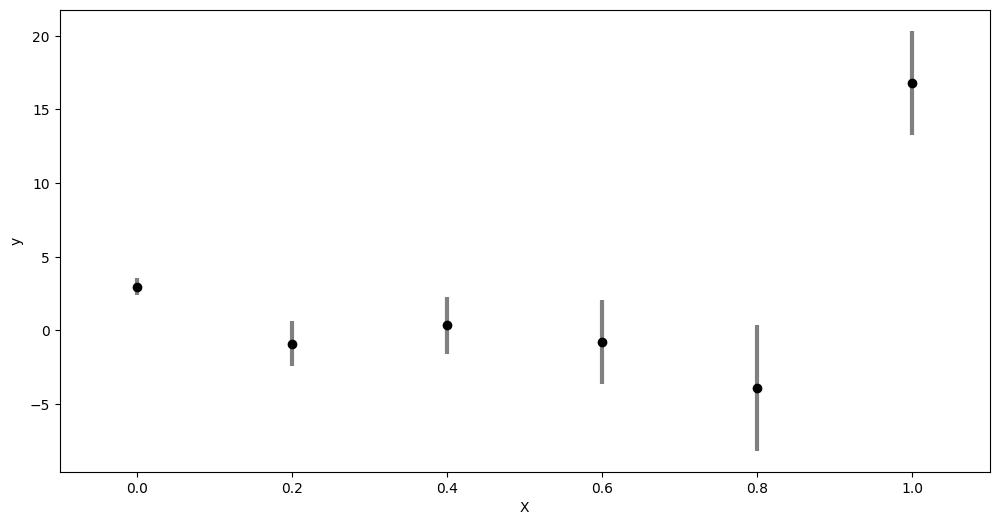

In [14]:
np.random.seed(1)

# Define the Forrester function
def forrester_function(x):
    return (6 * x - 2)**2 * np.sin(12 * x - 4)

# Function to generate variable noise based on X
def variable_noise(x):
    return 0.5 + 5 * x

# Generate X values
X = np.linspace(0, 1, 6)
#X = np.random.uniform(0, 1, 10)
num_measurements = 10  # Number of measurements per X

# Generate multiple noisy Y measurements for each X with variable noise
y_measurements = np.array([forrester_function(x) + np.random.normal(0, variable_noise(x), num_measurements) for x in X])

# Calculate mean and variance for Y measurements at each X
y = np.mean(y_measurements, axis=1)
measured_noise = np.var(y_measurements, axis=1)

# Plotting with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(
    X, y, yerr=np.sqrt(measured_noise), fmt='o', color='black', ecolor='grey',
    elinewidth=3, capsize=0)
plt.xlabel('X')
plt.ylabel('y')
plt.xlim(-0.1, 1.1)
plt.show()

Initialize and train ```MeasuredNoiseGP``` model.

In [15]:
# Get random number generator keys
key1, key2 = gpax.utils.get_keys()

# Initialize model
model = gpax.MeasuredNoiseGP(1, "Matern")

# Train
model.fit(key1, X, y, measured_noise)

sample: 100%|██████████| 4000/4000 [00:05<00:00, 743.97it/s, 3 steps of size 6.43e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.93      1.70      0.34      0.03      2.28    909.09      1.00
    k_scale      5.73      6.20      3.76      0.28     12.76   1002.84      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



Make a prediction on the denser grid (in real measurements, this will be a full discrete parameter space):

In [16]:
# Create a denser set of points
X_test = np.linspace(0, 1, 100)

# Make a prediction
y_pred, y_sampled = model.predict(key2, X_test, noise_prediction_method='gpreg', n=100)

Plot the prediction:

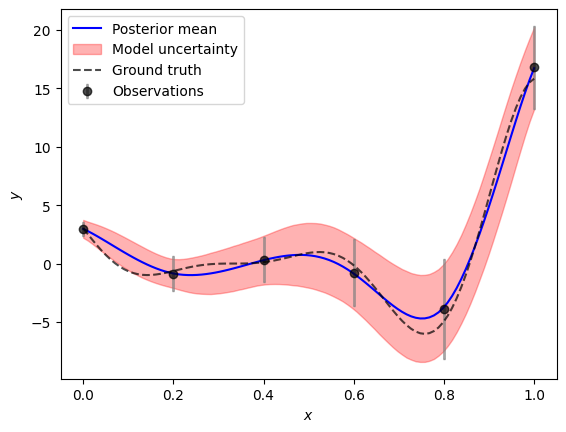

In [17]:
# Plot results
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.errorbar(
    X, y, yerr=np.sqrt(measured_noise), fmt='o', color='black', ecolor='grey',
    alpha=0.7, elinewidth=2, capsize=1, label='Observations', zorder=2)
ax.plot(X_test, y_pred, lw=1.5, zorder=2, c='b', label='Posterior mean')
ax.fill_between(X_test, y_pred - y_sampled.std(axis=(0,1)), y_pred + y_sampled.std(axis=(0,1)),
                color='r', alpha=0.3, label="Model uncertainty")
ax.plot(X_test, forrester_function(X_test), '--', label='Ground truth', c='k', alpha=0.7, zorder=2)
ax.legend(loc='best')

Plot the predicted noise for ```X_test```:

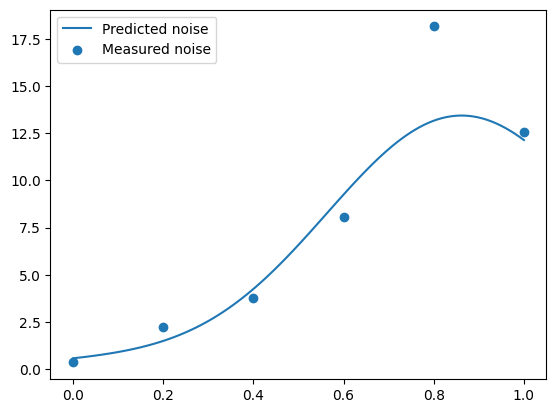

In [18]:
# Plot predicted (and measured) noise
plt.plot(X_test, model.noise_predicted, label="Predicted noise")
plt.scatter(X, measured_noise, label="Measured noise")
plt.legend()